# Data Loading

Before we can perform any model training, we need to load our data into a format that PyTorch can interact with.

## PyTorch Data Utilities

PyTorch provides two utilities for separating data handling code from model training code, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`, for storing and interacting with data respectively.

### `torch.utils.data.Dataset`

`torch.utils.data.Dataset` is an abstract class representing a dataset. Datasets in PyTorch are subclasses (children) of this base class (parent). PyTorch provides both built-in datasets and the ability to add your own datasets by instantiating subclasses of `torch.utils.data.Dataset`.

You can learn more about `torch.utils.data.Dataset` [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset). 

### `torch.utils.data.DataLoader`

`torch.utils.data.DataLoader` provides the ability to iterate over a dataset, and perform common operations on that data with support for multi-processing if desired. Operations supported include shuffling data, sampling data, loading data in batches, employing subprocesses to load the data, and more.

**Any class which is a subclass of `torch.utils.data.Dataset` can be passed to `torch.utils.DataLoader`.** This is incredibly convenient since any built-in dataset, and any data we add that is a subclass of `torch.utils.data.Dataset` is eligible to be interacted with through the convenience of `torch.utils.data.DataLoader`.

You can learn more about `torch.utils.data.DataLoader` [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

### Built-in Datasets

PyTorch includes many built-in subclasses of `torch.utils.data.Dataset`, all ready to be used and interacted with via `torch.utils.data.DataLoader`. Check out [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) as an example.

These include [vision datasets](https://pytorch.org/vision/stable/datasets.html), [text datasets](https://pytorch.org/text/stable/datasets.html), and [audio datasets](https://pytorch.org/audio/stable/datasets.html).

We will see examples of using built-in datasets and loading our own data below.

## Imports

Here we import the `torch` dependencies and other basic dependencies we'll need.

In [1]:
from dataclasses import dataclass

import torch

# Model building
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Data loading
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

# Visualization
import matplotlib.pyplot as plt

# Seed and device configuration
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Examples

Here we look at some examples of using PyTorch's builtin datasets and loading our own.

### Loading MNIST

Here we load MNIST.

Downloading the dataset might require dependencies. In this case, `gdown` is required and already installed in this environment. If it is not, you can install it with `pip install gdown` or `poetry add gdown` if using Poetry.

Different datasets support different arguments which control how they are loaded. Most datasets allow you to at minimum:

* specify a folder where the data is to be stored with `root`,
* Pass a transform you would like to apply to each example via the `transform` parameter,
* Specify that you want to download the dataset if it is *not* available at root via the `download` parameter.

We use transforms from `torchvision` to resize our images to a common size and transform them to PyTorch tensors.


In [2]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

dataset = datasets.MNIST(
    root="example_data", download=True, transform=transform
)

### Exploring MNIST

Let's learn about the data we just downloaded. We see that this is an object of class `torchvision.datasets.mnist.MNIST` which inherits from `torchvision.datasets.vision.VisionDataset`. Printing the dataset reveals some basic information.

In [3]:
print(type(dataset))
print(type(dataset).__base__)
print(dataset)

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.vision.VisionDataset'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: example_data
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )


We can see all the useful information packaged into this dataset by using Python's `dir` to get all the class's attributes and using list comprehension to remove any that have the `_` which indicates they are meant to be private.

In [4]:
def print_attributes(my_object):
    print(
        "\n".join(
            [
                attribute
                for attribute in dir(my_object)
                if not attribute.startswith("_")
            ]
        )
    )


print_attributes(dataset)

class_to_idx
classes
data
download
extra_repr
mirrors
processed_folder
raw_folder
resources
root
target_transform
targets
test_data
test_file
test_labels
train
train_data
train_labels
training_file
transform
transforms


We can inspect some of these attributes to get a feel for what the dataset enables us to do.

In [5]:
print("Annotation categories:", dataset.class_to_idx)
print("Categories:", dataset.classes)
print("Root directory of data:", dataset.root)
print("Transforms applied to data:", dataset.transforms)
print("Numerical labels:", dataset.targets)

Annotation categories: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
Categories: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Root directory of data: example_data
Transforms applied to data: StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )
Numerical labels: tensor([5, 0, 4,  ..., 5, 6, 8])


We can also see that indexing the data returns a tuple **at each index**. The first entry is the image and the second is the label.

We see that the dataset has 60000 entries, where each is a tuple. Each tuple has two elements, one for the features and one for the labels.

In [6]:
sample_index = 0
print(len(dataset))
print(type(dataset[sample_index]))
print(len(dataset[sample_index]))

# Image
print(dataset[sample_index][0])
print(dataset[sample_index][0].shape)

# Label
print(dataset[sample_index][1])

60000
<class 'tuple'>
2
Image([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000

We can visualize the contents of the dataset like we would any other data.

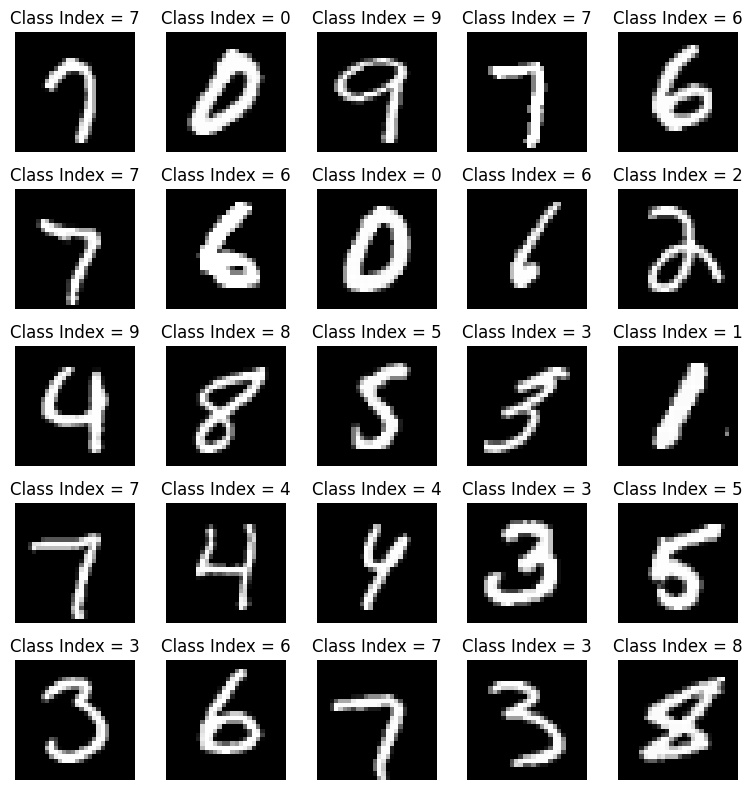

In [7]:
figure = plt.figure(figsize=(8, 8))
columns, rows = 5, 5
for index in range(1, columns * rows + 1):
    sample_index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[sample_index]
    figure.add_subplot(rows, columns, index)
    plt.axis("off")
    plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title("Class Index = {}".format(label))
    plt.tight_layout()
plt.show()

### Fitting a Model

To begin fitting a model, we start with a train-test split. We can use `torch.utils.data.random.split` to split the data up.

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

With the train-test split performed, we can now instantiate a `DataLoader` from each individual dataset. We can specify parameters for how we want the data loader object to interact with its user code, i.e., to shuffle (for training) or not shuffle (for testing).

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We can inspect the `DataLoader` objects to find out what classes they inherit from and what their attributes are. This gives us an idea for how we can interact with them. We see attributes which define the sampler, batch size, parallel processing configurations, and other parameters.

In [10]:
print(train_loader)
print(type(train_loader))
print(type(train_loader).__base__)
print_attributes(train_loader)

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'typing.Generic'>
batch_sampler
batch_size
check_worker_number_rationality
collate_fn
dataset
drop_last
generator
multiprocessing_context
num_workers
persistent_workers
pin_memory
pin_memory_device
prefetch_factor
sampler
timeout
worker_init_fn


Now we are ready to define a model, along with the functions we will need to train it.

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        y = F.log_softmax(x, dim=1)
        return y

In [12]:
@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    epochs: int = 3
    lr: float = 1.0
    gamma: float = 0.7
    dry_run: bool = False
    seed: int = 1
    save_model: bool = True


def predict(model, device, test_loader):
    """Make inferences using a given model and device, on a test set."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )


def run_training_epoch(
    training_params, model, device, train_loader, optimizer, epoch
):
    """Execute a single training epoch."""
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if training_params.dry_run:
            break
        if batch_index % round(len(train_loader) / 79 + 1) == 0:
            print(".", end="")
    print("")
    print("Train Epoch: {} \tLoss: {:.6f}".format(epoch, loss.item()))

    if training_params.save_model:
        torch.save(model.state_dict(), "models/mnist_cnn.pt")


def train(model, training_params, device, train_loader, test_loader):
    """Cycle through epochs to train the given model."""
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

In [13]:
model = SimpleCNN().to(device)
training_params = TrainingParameters(epochs=3, dry_run=False)
train(model, training_params, device, train_loader, test_loader)

...........................................................................
Train Epoch: 1 	Loss: 0.015588

Test set: Average loss: 0.0671, Accuracy: 11759/12000 (98%)

...........................................................................
Train Epoch: 2 	Loss: 0.010652

Test set: Average loss: 0.0572, Accuracy: 11812/12000 (98%)

...........................................................................
Train Epoch: 3 	Loss: 0.007514

Test set: Average loss: 0.0483, Accuracy: 11823/12000 (99%)



## Creating a Custom Dataset

By extending the Dataset class and implementing the required functions we can create custom datasets for use with PyTorch.

Here we start by getting some data as a numpy array using the `pydatapull` repository, which is a submodule of this project.

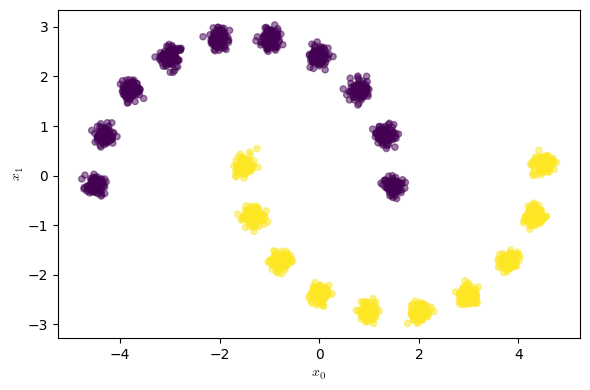

In [14]:
from pydatapull.basicml import generate_half_moon_dataset
from pydatapull.visualizers import scatter_plot_dataset

x_half_moon_features, y_half_moon_labels, _ = generate_half_moon_dataset(
    n_samples_per_class=1000,
    n_clusters_per_class=10,
    radius_r=3,
    separation_offset_d=-0.2,
    sigma=0.1,
)
_ = scatter_plot_dataset(x_half_moon_features, y_half_moon_labels)

To create a custom dataset, we create a class which inherits from the `Dataset` object and implements the `__init__`, `__len__` and `__getitem__` methods which user code will use to interact with our dataset. The `__init__` function accepts the data as numpy arrays, and sets the `data`, `labels`, and `transforms` members. The `__len__` function returns the number of samples in our data to the user code. Finally, the `__getitem__` function returns a single sample and its corresponding label as a tuple. In this case, a sample is a row of the array of features, and its label is a corresponding number indicating which class it belongs to.

In [15]:
class NumpyDataset(Dataset):
    def __init__(self, x_features_array, y_labels, transform=None):
        self.data = x_features_array
        self.labels = y_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        sample = torch.tensor(sample, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        return sample, label

Now we can use the class we created to generate a dataset from numpy arrays.

In [16]:
half_moon_dataset = NumpyDataset(x_half_moon_features, y_half_moon_labels)

Now the we have created a dataset with a class that conforms to the right interfaces, we can use it like any other PyTorch dataset. Here we perform a train-test split and generate a pair of data loaders for training and testing. Just like the datasets we have seen before, each element of each dataset is a tuple with an entry for the data sample and an entry for the label. Each data loader's length represents the number of batches required to represent the entire dataset.

In [17]:
train_size = int(0.8 * len(half_moon_dataset))
test_size = len(half_moon_dataset) - train_size
half_moon_train_dataset, half_moon_test_dataset = (
    torch.utils.data.random_split(half_moon_dataset, [train_size, test_size])
)

print(half_moon_train_dataset[0])
print(half_moon_train_dataset[0][0])
print(half_moon_train_dataset[0][1])

half_moon_train_loader = DataLoader(
    half_moon_train_dataset, batch_size=64, shuffle=True
)
half_moon_test_loader = DataLoader(
    half_moon_test_dataset, batch_size=64, shuffle=False
)
print(len(half_moon_train_loader))
print(len(half_moon_test_loader))

(tensor([ 1.2385, -0.1535]), tensor(0.))
tensor([ 1.2385, -0.1535])
tensor(0.)
25
7


## Creating a Custom Dataset from Files

We can also create custom datasets from files. The following example is borrowed almost entirely from [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) with an RUC twist. We again implement a child that inherits from the `Dataset` class and implements the member functions `__init__`, `__len__`, and `__getitem__`.

In [18]:
import os
import pandas as pd
from torchvision.io import read_image


class CustomImageDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Here we can use the dataset class we just implemented to load a custom dataset. The text file defines the labels for each image. All images in `img_dir` are loaded.

In [19]:
custom_image_dataset = CustomImageDataset(
    annotations_file="./example_data/custom_dataset/labels.txt",
    img_dir="./example_data/custom_data",
)

Now we can perform a train-test split and initialize our data loaders.

In [20]:
train_size = int(0.8 * len(custom_image_dataset))
test_size = len(custom_image_dataset) - train_size
custom_image_train_dataset, custom_image_test_dataset = (
    torch.utils.data.random_split(
        custom_image_dataset, [train_size, test_size]
    )
)

custom_image_train_loader = DataLoader(
    custom_image_train_dataset, batch_size=64, shuffle=True
)
custom_image_test_loader = DataLoader(
    custom_image_test_dataset, batch_size=64, shuffle=False
)